# Nighttime Lights Trends in Ethiopia

In a world marked by diverse forms of conflict, from armed confrontations to civil unrest, [NASA's Black Marble Nighttime Lights](https://blackmarble.gsfc.nasa.gov) dataset offers an unconventional yet powerful tool for understanding the ripple effects of these conflicts on human settlements and infrastructure. By tracking nighttime light variations and disruptions, we can unearth insights into population displacement, economic destabilization, and the societal impacts of conflict. This analysis explores the potential of a nighttime lights dataset to not only detect areas affected by conflict but also to quantify the extent of its influence on livelihoods and on the economy, providing a valuable perspective on the multifaceted consequences of conflict.

## Data 

This analysis used Nighttime Lights data from NASA BlackMarble and shapefiles from GADM (which is slightly different from the shapefiles used in the analysis for Air Pollution). In the next version of the analysis, the shapefiles will be changed so the analysis can become more comparable. 

### NASA Black Marble 

[NASA's Black Marble](https://blackmarble.gsfc.nasa.gov) product suite represents a remarkable advancement in our ability to monitor and understand nocturnal light emissions on a global scale. By utilizing cutting-edge satellite technology and image processing techniques, the Black Marble VIIRS dataset offers a comprehensive and high-resolution view of the Earth's nighttime illumination patterns. To obtain the raster data conveniently and calculate zonal statistics, we use the [BlackMarblePy](https://worldbank.github.io/blackmarblepy/README.html) {cite}`10.5281/zenodo.10667925` package developed by the World Bank.


```{important}
The [VNP46A2 Daily Moonlight-adjusted Nighttime Lights (NTL) Product](https://blackmarble.gsfc.nasa.gov/VNP46A2.html) is [available daily](datahttps://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A2/#data-availability). However, due data quality, cloud cover or other factors, the data may not be available always at a specific location.
```

In [2]:
import os
from datetime import datetime

#import colorcet as cc
import folium
import geopandas
import pandas as pd
#from blackmarble.extract import bm_extract
from bokeh.models import HoverTool, Legend, Range1d, Span, Title
from bokeh.plotting import figure, output_notebook, show

%load_ext autoreload
%autoreload 2

**Region of Interest**

In [47]:
ethiopia_adm1 = geopandas.read_file('../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp')
ethiopia_adm2 = geopandas.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')
#ethiopia.explore()

In [3]:
import numpy as np

def get_annual_percent_change(df, group_columns=['ADM1_EN'], baseline_year='PY', column='ntl_sum'):
    df = df.copy()
    df['year'] = df['date'].dt.year
    baseline_column = f'baseline_{column}_{baseline_year}'
    column_name = f'percent_change_{column}_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute annual baseline NO2 for the specified baseline year
        
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_columns)[column]
            .mean()
            .reset_index()
            .rename(columns={column: baseline_column})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=group_columns, how='left')    

    # Compute the annual percentage change
        df[column_name] = np.where(
    df[baseline_column] == 0,  # Check if baseline value is zero
    np.nan,  # Assign NaN (or use 0 if preferred)
    ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
)


    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's annual baseline
            
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_columns)[column]
                .mean()
                .reset_index()
                .rename(columns= {column:baseline_column})
            )
            

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, group_columns].merge(
                baseline_df, on=group_columns, how='left'
            )[baseline_column].values


            df[column_name] = np.where(
    df[baseline_column] == 0,  # Check if baseline value is zero
    np.nan,  # Assign NaN (or use 0 if preferred)
    ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
)


    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    

    return df


In [4]:
import numpy as np

def get_monthly_percent_change(df, group_columns=[], baseline_year='PY', column='ntl_sum'):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    baseline_column = f'baseline_{column}_{baseline_year}'
    column_name = f'percent_change_{column}_{baseline_year}'

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute monthly NO2 baseline for the specified baseline year
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_columns + ['month'])[column]
            .mean()
            .reset_index()
            .rename(columns={column: baseline_column})
        )


        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=group_columns +['month'], how='left')

        df[column_name] = np.where(
            df[baseline_column] == 0,  # Check if baseline value is zero
            np.nan,  # Assign NaN (or use 0 if preferred)
            ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
        )


    elif baseline_year == 'PY':  # Previous year case
        df[baseline_column] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's monthly baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_columns +  ['month'])[column]
                .mean()
                .rename(baseline_column)
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, baseline_column] = df.loc[df['year'] == year, group_columns + ['month']].apply(
    lambda row: baseline_df.get(tuple(row[group_columns]) + (row['month'],)), axis=1)


            df[column_name] = np.where(
            df[baseline_column] == 0,  # Check if baseline value is zero
            np.nan,  # Assign NaN (or use 0 if preferred)
            ((df[column] - df[baseline_column]) / df[baseline_column]) * 100
        )


    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")
    
    column_name = f'percent_change_{column}_{baseline_year}'

    # Compute the monthly percentage change
    

    return df


## Methodology

We created a time series of weekly radiance using NASA's Black Marble data which involves several steps, including data acquisition, pre-processing, zonal statistics calculation, and time series generation. The zonal statistics of the aggregated sum of nighttime lights is used to make inferences. 

In [4]:
df1 = pd.read_csv('../../data/nighttime-lights/aggregated/2024/ntl_adm0_monthly.csv')
df1 = df1[df1['date']>'2023-12-01']
df1['COUNTRY']='Ethiopia'

In [83]:
import pandas as pd

# Read the data from the first set of files (no date filtering needed)
ntl_adm2_monthly_1 = pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm2_monthly.csv')
ntl_adm1_monthly_1 = pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm1_monthly.csv')
ntl_adm0_monthly_1 = pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm0_monthly.csv')

# Read the data from the second set of files (2024 folder)
ntl_adm2_monthly_2 = pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin2_monthly.csv')
ntl_adm1_monthly_2 = pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin1_monthly.csv')
ntl_adm0_monthly_2 = pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin0_monthly.csv')

# Convert 'date' column to datetime format
ntl_adm2_monthly_1['date'] = pd.to_datetime(ntl_adm2_monthly_1['date'])
ntl_adm1_monthly_1['date'] = pd.to_datetime(ntl_adm1_monthly_1['date'])
ntl_adm0_monthly_1['date'] = pd.to_datetime(ntl_adm0_monthly_1['date'])

ntl_adm2_monthly_2['date'] = pd.to_datetime(ntl_adm2_monthly_2['date'])
ntl_adm1_monthly_2['date'] = pd.to_datetime(ntl_adm1_monthly_2['date'])
ntl_adm0_monthly_2['date'] = pd.to_datetime(ntl_adm0_monthly_2['date'])

# Filter the second set of files (2024_2) to only include October - December 2024
start_date = pd.to_datetime('2024-10-01')
end_date = pd.to_datetime('2024-12-31')

filtered_ntl_adm2_2 = ntl_adm2_monthly_2[(ntl_adm2_monthly_2['date'] >= start_date) & (ntl_adm2_monthly_2['date'] <= end_date)]
filtered_ntl_adm1_2 = ntl_adm1_monthly_2[(ntl_adm1_monthly_2['date'] >= start_date) & (ntl_adm1_monthly_2['date'] <= end_date)]
filtered_ntl_adm0_2 = ntl_adm0_monthly_2[(ntl_adm0_monthly_2['date'] >= start_date) & (ntl_adm0_monthly_2['date'] <= end_date)]

# Concatenate the first set of files with the filtered second set of files
ntl_adm2_monthly = pd.concat([ntl_adm2_monthly_1, filtered_ntl_adm2_2])
ntl_adm1_monthly = pd.concat([ntl_adm1_monthly_1, filtered_ntl_adm1_2])
ntl_adm0_monthly = pd.concat([ntl_adm0_monthly_1, filtered_ntl_adm0_2])


In [18]:

# ntl_admin2_monthly = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm2_monthly.csv'),
#                                 pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin2_monthly.csv')])
# ntl_admin1_monthly = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm1_monthly.csv'),
#                                 pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin1_monthly.csv')])
# ntl_admin0_monthly = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm0_monthly.csv'),
#                                 pd.read_csv('../../data/nighttime-lights/aggregated/2024_2/ntl_admin1_monthly.csv')])

# # ntl_admin0_annual = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm0_annual.csv')])
# # ntl_admin1_annual = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm1_annual.csv'),
# #                                 pd.read_csv('../../data/nighttime-lights/aggregated/2024/ntl_adm1_annual.csv')])
# # ntl_admin2_annual = pd.concat([pd.read_csv('../../data/nighttime-lights/aggregated/ntl_adm2_annual.csv'),
# #                                pd.read_csv('../../data/nighttime-lights/aggregated/2024/ntl_adm2_annual.csv')])

In [ ]:
#ntl_admin0_annual['date'] = pd.to_datetime(ntl_admin0_annual['date'], format='%Y')
#ntl_admin1_annual['date'] = pd.to_datetime(ntl_admin1_annual['date'], format='%Y')
#ntl_admin2_annual['date'] = pd.to_datetime(ntl_admin2_annual['date'], format='%Y')

In [21]:
#ntl_admin1_monthly['ADM1_EN'] = ntl_admin1_monthly['ADM1_EN'].replace({'Benishangul Gumz':'Benshangul-Gumaz', 'Gambela':'Gambela Peoples','Harari':'Harari People', 'Sidama':'Southern Nations, Nationalities', 'SNNP':'Southern Nations, Nationalities', 'South West Ethiopia':'Southern Nations, Nationalities'})
#ntl_admin1_annual['ADM1_EN'] = ntl_admin1_annual['ADM1_EN'].replace({'Benishangul Gumz':'Benshangul-Gumaz', 'Gambela':'Gambela Peoples','Harari':'Harari People', 'Sidama':'Southern Nations, Nationalities', 'SNNP':'Southern Nations, Nationalities', 'South West Ethiopia':'Southern Nations, Nationalities'})


In [22]:
#ntl_admin1_monthly['NAME_1'].fillna(ntl_admin1_monthly['ADM1_EN'], inplace=True)
#ntl_admin1_annual['NAME_1'].fillna(ntl_admin1_annual['ADM1_EN'], inplace=True)


In [23]:
# def get_percent_change(df, baseline_year, column, group_by_columns):
#     """
#     Calculate percent change for each group based on the baseline year.

#     Parameters:
#     - df: DataFrame containing the data.
#     - baseline_year: Year used as the baseline for percent change calculation.
#     - column: Column to calculate the percent change for.
#     - group_by_columns: List of columns to group by (e.g., admin regions).

#     Returns:
#     - DataFrame with an additional 'percent_change' column.
#     """
#     df['year'] = df['date'].dt.year
#     df['month'] = df['date'].dt.month

#     # Calculate the baseline for each group
#     baseline = (
#         df[df['year'] == baseline_year]
#         .groupby(group_by_columns)[column]
#         .mean()
#         .reset_index()
#         .rename(columns={column: 'baseline'})
#     )
#     #print(baseline[baseline['NAME_2']=='Korahe'])

#     # Merge the baseline values back into the original DataFrame
#     df = df.merge(baseline, on=group_by_columns, how='left')

#     #print(df[df['NAME_2']=='Korahe'][['ntl_sum', 'baseline', 'date']])

#     # Calculate percent change
#     df['percent_change'] = 0.0  # Initialize with 0
#     df['percent_change'] = 100*(df[column] - df['baseline'])/df['baseline']

#     # Clean up temporary columns if needed
#     df = df.drop(columns=['baseline'])

#     return df


In [ ]:
# ntl_admin0_monthly['date'] = pd.to_datetime(ntl_admin0_monthly['date'])
# ntl_admin1_monthly['date'] = pd.to_datetime(ntl_admin1_monthly['date'])
# ntl_admin2_monthly['date'] = pd.to_datetime(ntl_admin2_monthly['date'])


In [85]:
ntl_adm0_annual = ntl_adm0_monthly.groupby(['COUNTRY', pd.Grouper(key='date', freq='YS')])[['ntl_sum']].mean().reset_index()
ntl_adm1_annual = ntl_adm1_monthly.groupby(['COUNTRY','NAME_1', pd.Grouper(key='date', freq='YS')])[['ntl_sum']].mean().reset_index()
ntl_adm2_annual = ntl_adm2_monthly.groupby(['COUNTRY','NAME_1', 'NAME_2',pd.Grouper(key='date', freq='YS')])[['ntl_sum']].mean().reset_index()

In [245]:
# #ntl_admin0_monthly['COUNTRY'] = ntl_admin0_monthly['COUNTRY'].fillna('Ethiopia')
# ntl_admin0_annual_mean = ntl_admin0_monthly.groupby([pd.Grouper(key='date', freq='YS'), 'ADM0_EN'])[['ntl_sum']].mean().reset_index()

In [86]:
ntl_adm0_monthly = get_monthly_percent_change(ntl_adm0_monthly, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY'])
ntl_adm0_monthly = get_monthly_percent_change(ntl_adm0_monthly, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY'])

ntl_adm1_monthly = get_monthly_percent_change(ntl_adm1_monthly, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY', 'NAME_1'])
ntl_adm1_monthly = get_monthly_percent_change(ntl_adm1_monthly, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY', 'NAME_1'])

# ntl_admin2_monthly = get_monthly_percent_change(ntl_admin2_monthly, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])
# ntl_admin2_monthly = get_monthly_percent_change(ntl_admin2_monthly, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])

ntl_adm0_annual = get_annual_percent_change(ntl_adm0_annual, baseline_year=2019, column='ntl_sum',group_columns=['COUNTRY'] )
ntl_adm0_annual = get_annual_percent_change(ntl_adm0_annual, baseline_year='PY', column='ntl_sum',group_columns=['COUNTRY'] )

ntl_adm1_annual = get_annual_percent_change(ntl_adm1_annual, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY', 'NAME_1'])
ntl_adm1_annual = get_annual_percent_change(ntl_adm1_annual, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY', 'NAME_1'])

ntl_adm2_annual = get_annual_percent_change(ntl_adm2_annual, baseline_year=2019, column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])
ntl_adm2_annual = get_annual_percent_change(ntl_adm2_annual, baseline_year='PY', column='ntl_sum', group_columns=['COUNTRY', 'NAME_1', 'NAME_2'])

In [30]:
wb = pd.read_csv('../../data/general/API_ETH_DS2_en_csv_v2_6837.csv', skiprows=4)

In [87]:
population = wb[wb['Indicator Code'].isin(['SP.POP.TOTL'])]
gdp = wb[wb['Indicator Code'].isin(['NY.GDP.PCAP.CD', 'NY.GDP.MKTP.CD'])]


In [88]:
gdp = gdp.drop(columns=['Country Code', 'Country Name', 'Indicator Code']).set_index('Indicator Name').T.reset_index()
gdp = gdp.rename(columns={'index':'Year'})
gdp = gdp.dropna(subset='GDP per capita (current US$)')
gdp['Year'] = pd.to_datetime(gdp['Year'], format='%Y')
gdp = gdp[['Year', 'GDP (current US$)', 'GDP per capita (current US$)']]

In [89]:
population = population.drop(columns=['Country Code', 'Country Name', 'Indicator Code']).set_index('Indicator Name').T.reset_index()
population = population.rename(columns={'index':'Year'})
population = population.dropna(subset = 'Population, total')
population['Year'] = pd.to_datetime(population['Year'], format='%Y')

### Insights

#### National Trends of Nighttime Lights

In [117]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from acled_conflict_analysis import visuals


output_notebook()

df = ntl_adm0_annual
df['date'] = pd.to_datetime(df['date'])

tabs = []

for measure in ['ntl_sum', 'percent_change_ntl_sum_2019', 'percent_change_ntl_sum_PY']:
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                "Annual National Nighttime Lights",
                "Source: NASA BlackMarble. World Bank estimates",
                # subtitle = "",
                category = 'COUNTRY',
                measure=measure,
                event_date='date'
    )

 
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

**2024 Annual Nighttime Lights is not available yet. Monthly data is released and hence, the data for 2024 has been averaged over the months.** The overall trend in nighttime lights saw a steady increase with additional increase in 2017 and minor dips in 2016 and 2019. 

In [39]:
import bokeh
from bokeh.core.validation.warnings import MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span, Range1d, LinearAxis
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel, Label
import pandas as pd
from acled_conflict_analysis import visuals

bokeh.core.validation.silence(MISSING_RENDERERS, True)

output_notebook()

df = ntl_adm0_annual
df['date'] = pd.to_datetime(df['date'])

tabs = []

# Loop through comparative data
for comparative, column_name in [(gdp, 'GDP'), (population, 'Population')]:
    # Correctly filter comparative data starting from 2012
    comparative = comparative[comparative['Year'] >= pd.Timestamp('2012-01-01')]

    ntl_min = ntl_adm0_annual['ntl_sum'].min()
    ntl_max = ntl_adm0_annual['ntl_sum'].max()

    # Create the figure
    p = figure(
        title=f"Annual National Nighttime Lights Compared with {column_name}",
        x_axis_label='Year',
        y_axis_label='Nighttime Lights',
        x_axis_type='datetime',
        width=800,
        height=400,
        sizing_mode=None,
        y_range=Range1d(start=ntl_min, end=ntl_max),
    )

    # Plot the primary data (NTL)
    p.line(
        x=ntl_adm0_annual['date'],
        y=ntl_adm0_annual['ntl_sum'],
        line_width=2,
        color='blue',
        legend_label="NTL Sum",
    )

    # Configure the secondary axis with independent range
    secondary_min = comparative[comparative.columns[1]].min()
    secondary_max = comparative[comparative.columns[1]].max()
    p.extra_y_ranges = {"secondary": Range1d(start=secondary_min, end=secondary_max)}
    p.add_layout(LinearAxis(y_range_name="secondary", axis_label=comparative.columns[1]), 'right')

    # Plot the comparative data on the secondary axis
    p.line(
        x=comparative['Year'],
        y=comparative[comparative.columns[1]],
        line_width=2,
        color='red',
        y_range_name="secondary",
        legend_label=comparative.columns[1],
    )

    subtitle = Label(
        x=-0.1, y=-3, x_units='screen', y_units='screen',
        text="Source: NASA BlackMarble and World Bank estimates",
        text_font_size="10pt",
        text_align="left"
    )
    p.add_layout(subtitle)

    # Add the tab
    tab = TabPanel(child=p, title=column_name)
    tabs.append(tab)

# Create and display the tabs
tabs_layout = Tabs(tabs=tabs, sizing_mode=None)
show(tabs_layout)



Loading BokehJS ...

**The Population and GDP of the country shows a similar increase as in NTL. However, the dips ain 2019 and 2019 and the rise in 2017 is not seen.** The last available year for this data is also 2023. 

In [123]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from acled_conflict_analysis import visuals


output_notebook()

df = ntl_adm0_monthly.copy()
df
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date':'event_date'})

tabs = []

for measure in ['ntl_sum', 'percent_change_ntl_sum_2019', 'percent_change_ntl_sum_PY']:
    # Get the line plot for monthly NO2
    p = visuals.get_bar_chart(
                df,
                "Monthly National Nighttime Lights",
                "Source: NASA BlackMarble. World Bank estimates",
                category = 'COUNTRY',
                measure=measure,
                category_value='Ethiopia',
                color_code='#1AA1DB',
                width=1500000000
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(ntl_admin0_annual['event_date'].dt.year, format='%Y'), y=ntl_admin0_annual[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

**All percentage change values consider 2019 as a baseline year. 2024 saw a reduction in lights compared to 2023**

#### Percentage change in subnational annual nighttime lights compared to 2019

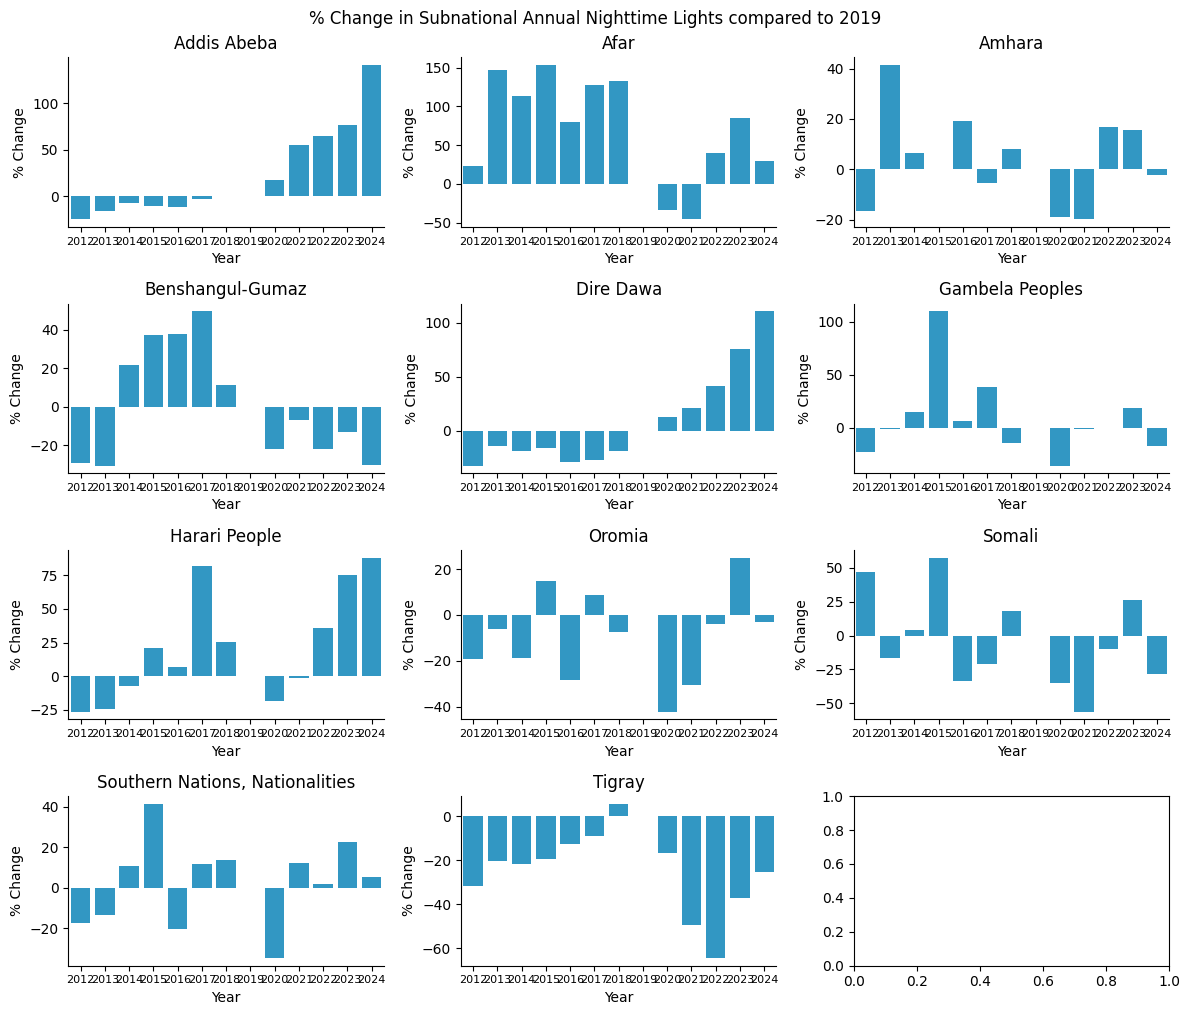

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

ntl_adm1_annual.dropna(subset=['NAME_1'], inplace=True)

fig, axes = plt.subplots(4, 3, figsize=(12, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region
for i, region in enumerate(ntl_adm1_annual['NAME_1'].unique()):
    ax = axes[i]
    df = ntl_adm1_annual[ntl_adm1_annual['NAME_1']==region]
    # df = df.set_index('date')
    df.loc[:, 'year'] = pd.to_datetime(df['date']).dt.year

    sns.barplot(data=df, x='year', y='percent_change_ntl_sum_2019', color='#1AA1DB', ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Year')
    ax.set_ylabel('% Change')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='x', labelsize=8)

#Hide extra subplots if regions < grid cells
for j in range(len(df['NAME_1'])-1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('% Change in Subnational Annual Nighttime Lights compared to 2019', x=0.5, y=1.01)
plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

**Not all admin regions saw an increase in NTL compared to 2019.** Tigray region saw a reduction in lights since 2019. Afar and Benshangul-Gumaz saw little change in light from 2019. 

#### Trends in subnational annual nighttime lights

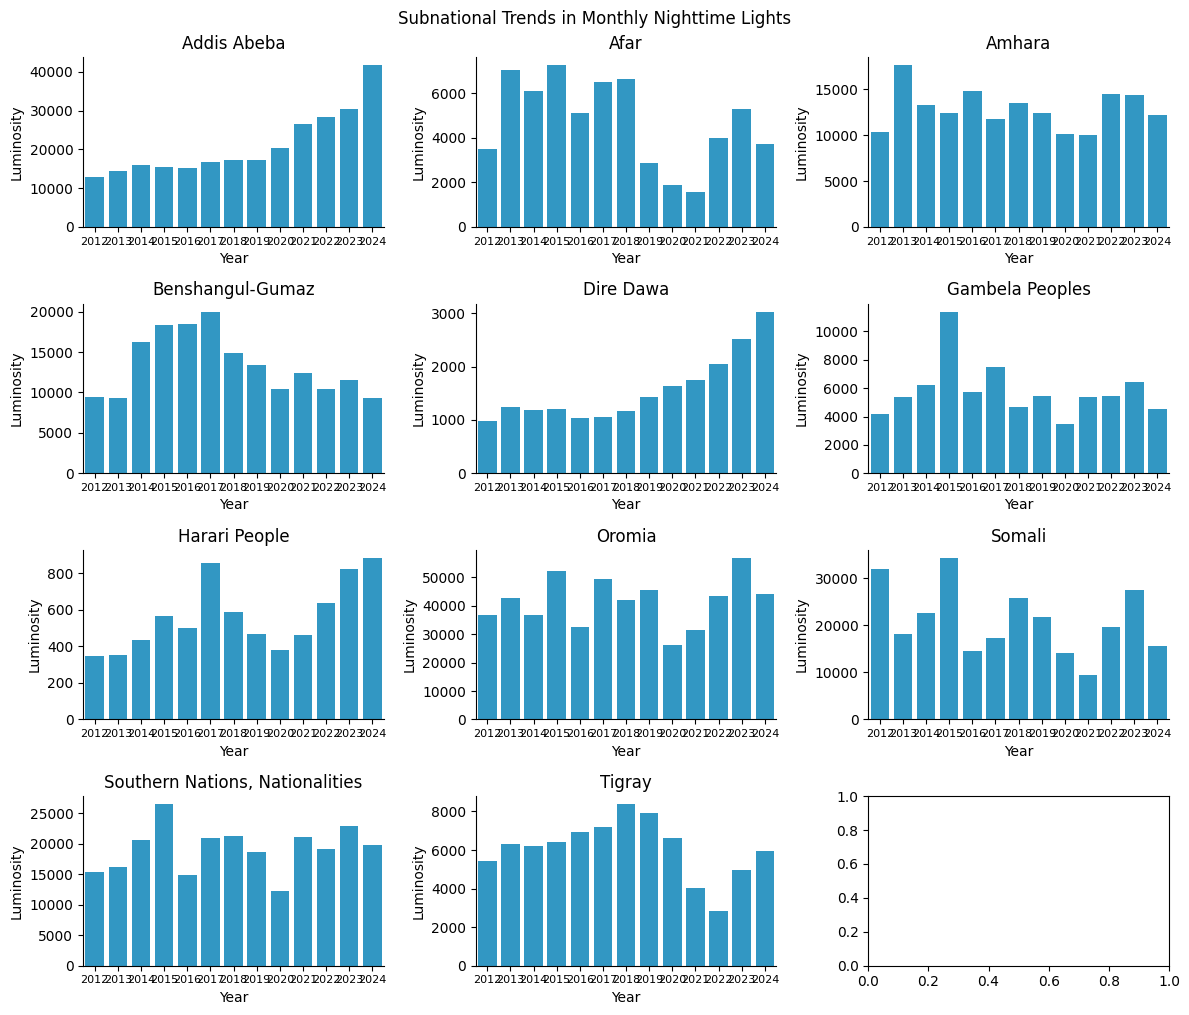

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(12, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region
for i, region in enumerate(ntl_adm1_annual['NAME_1'].unique()):
    ax = axes[i]
    df = ntl_adm1_annual[ntl_adm1_annual['NAME_1']==region]
    # df = df.set_index('date')
    df.loc[:, 'year'] = pd.to_datetime(df['date']).dt.year

    sns.barplot(data=df, x='year', y='ntl_sum', color='#1AA1DB', ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Year')
    ax.set_ylabel('Luminosity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='x', labelsize=8)

#Hide extra subplots if regions < grid cells
for j in range(len(df['NAME_1'])-1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('Subnational Trends in Monthly Nighttime Lights', x=0.5, y=1.01)
plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

**There was a considerable increase in light in Afar in 2017. Most other regions also saw an increase in light in that year.** Somali and SNNR has shown a consistent rise in NTL. Tigray region saw a drop in NTL in 2022, potentially because of the war. 

#### Monthly Trends in Nighttime Lights from 2019

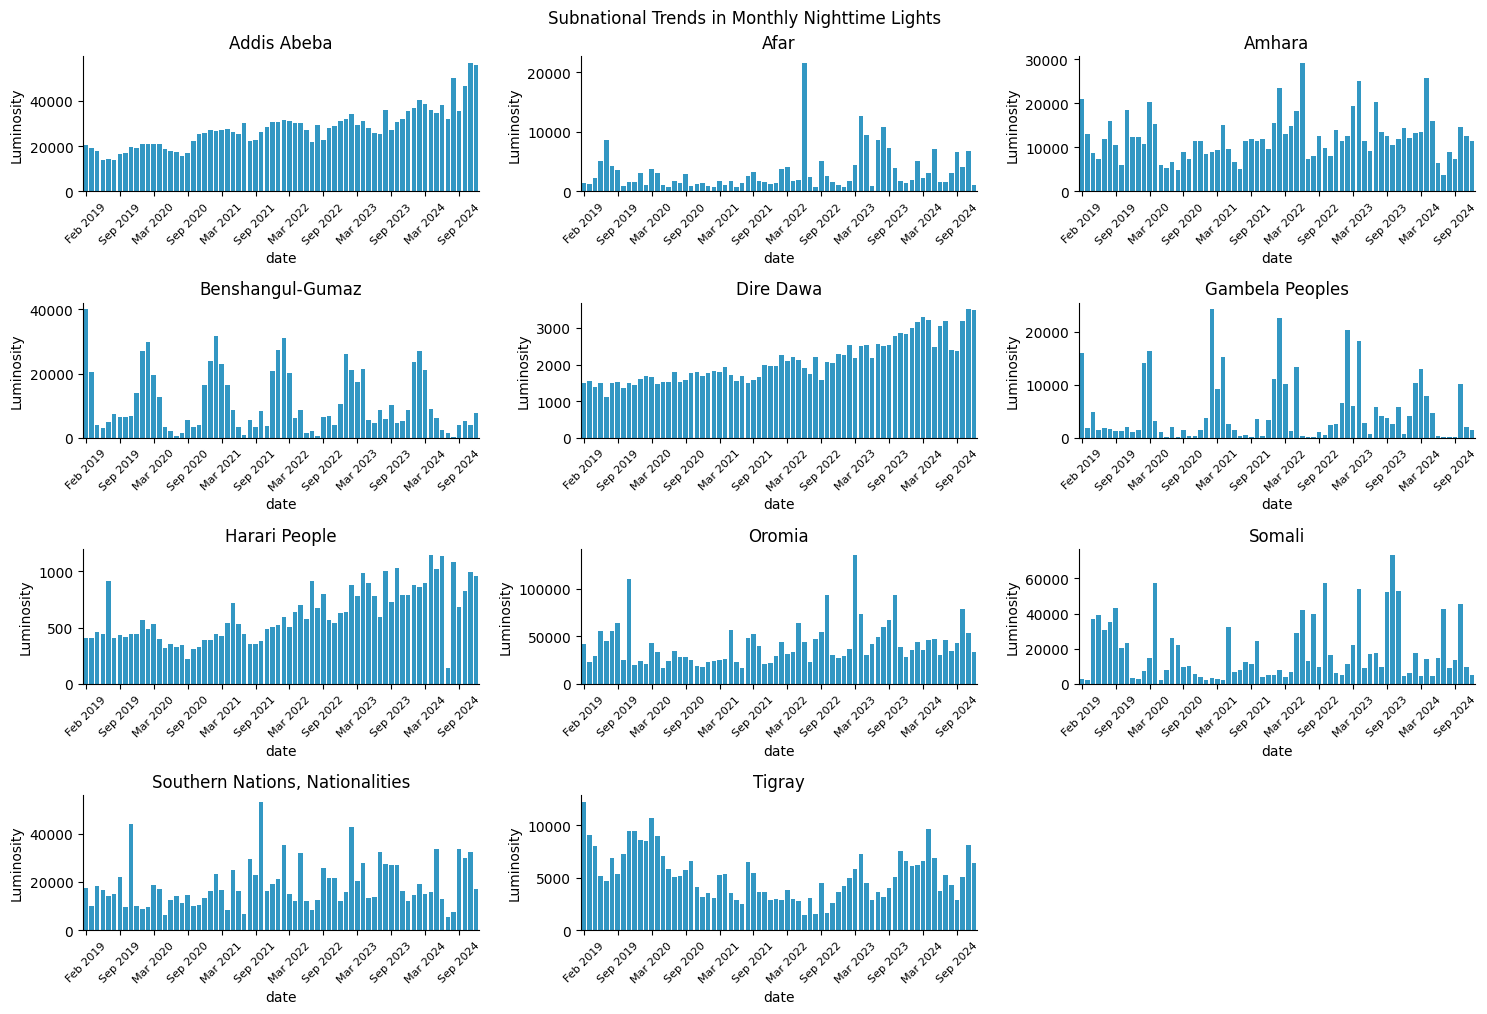

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region
for i, region in enumerate(ntl_adm1_monthly['NAME_1'].unique()):
    ax = axes[i]
    df = ntl_adm1_monthly[ntl_adm1_monthly['NAME_1']==region]
    df = df[df['date']>'2019-01-01']
    # df = df.set_index('date')
    df.loc[:, 'year'] = pd.to_datetime(df['date']).dt.year

    sns.barplot(data=df, x='date', y='ntl_sum', color='#1AA1DB', ax=ax)
    ax.set_title(region)
    #ax.set_xlabel('Date')
    ax.set_ylabel('Luminosity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    tick_positions = range(0, len(df['date']), 6)  # Every 6th month
    tick_labels = pd.to_datetime(df['date']).iloc[tick_positions].dt.strftime('%b %Y')  # Format as 'Month Year'
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)

#Hide extra subplots if regions < grid cells
for j in range(len(ntl_adm1_monthly['NAME_1'].unique()), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('Subnational Trends in Monthly Nighttime Lights', x=0.5, y=1.01)
plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

In [144]:
import geopandas as gpd 

ethiopia_adm1 = gpd.read_file('../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp')
ethiopia_adm2 = gpd.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')
ethiopia_adm3 = gpd.read_file('../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp')

In [48]:
import geopandas as gpd

ethiopia_adm1_gadm = gpd.read_file('../../data/boundaries/gadm/ETH_GADM_level1.shp')
ethiopia_adm2_gadm = gpd.read_file('../../data/boundaries/gadm/ETH_GADM_level2.shp')

In [93]:
# ntl_adm1_annual.drop(columns='geometry', inplace=True)
# ntl_adm2_annual.drop(columns='geometry', inplace=True)

ntl_admin1_annual_gdf = ntl_adm1_annual.merge(ethiopia_adm1_gadm[['COUNTRY', 'NAME_1', 'geometry']], on=['COUNTRY','NAME_1'])
ntl_admin2_annual_gdf = ntl_adm2_annual.merge(ethiopia_adm2_gadm[['COUNTRY', 'NAME_1','NAME_2', 'geometry']], on=['COUNTRY','NAME_1', 'NAME_2'])

In [91]:
ntl_adm1_monthly.drop(columns='geometry', inplace=True)
ntl_adm2_monthly.drop(columns='geometry', inplace=True)

ntl_admin1_monthly_gdf = ntl_adm1_monthly.merge(ethiopia_adm1_gadm[['COUNTRY', 'NAME_1', 'geometry']], on=['COUNTRY','NAME_1'])
ntl_admin2_monthly_gdf = ntl_adm2_monthly.merge(ethiopia_adm2_gadm[['COUNTRY', 'NAME_1','NAME_2', 'geometry']], on=['COUNTRY','NAME_1', 'NAME_2'])

In [57]:
from shapely.geometry import Polygon, Point

ntl_admin1_annual_gdf = gpd.GeoDataFrame(ntl_admin1_annual_gdf, geometry='geometry')
ntl_admin2_annual_gdf = gpd.GeoDataFrame(ntl_admin2_annual_gdf, geometry='geometry')

In [95]:
ntl_admin1_monthly_gdf = gpd.GeoDataFrame(ntl_admin1_monthly_gdf, geometry='geometry')
ntl_admin2_monthly_gdf = gpd.GeoDataFrame(ntl_admin2_monthly_gdf, geometry='geometry')

#### Geospatial Representation of Nighttime Lights

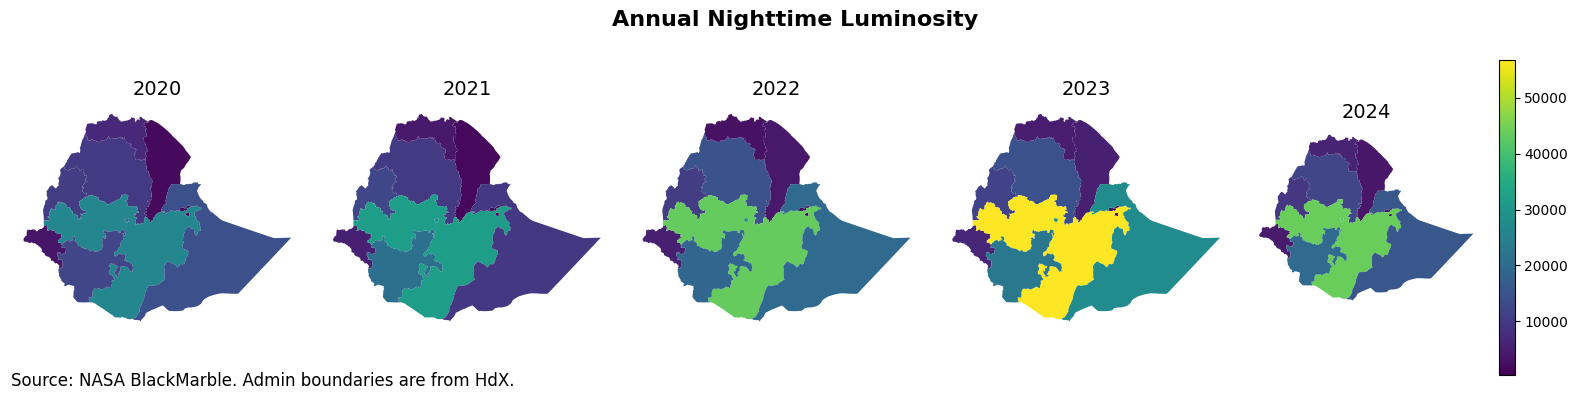

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]



# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date']>'2019-01-01']['ntl_sum'].min()
vmax = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date']>'2019-01-01']['ntl_sum'].max()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 4),  gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date'] == f'{year}-01-01']
    
    # Add the legend only to the last plot
    legend = (idx == len(years) - 1)
    
    # Plot on the respective subplot
    filtered_data.plot(
        column='ntl_sum',
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap='viridis'  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle('Annual Nighttime Luminosity', fontsize=16, y=0.95, fontweight='bold')

plt.figtext(0.01, 0.01, "Source: NASA BlackMarble. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


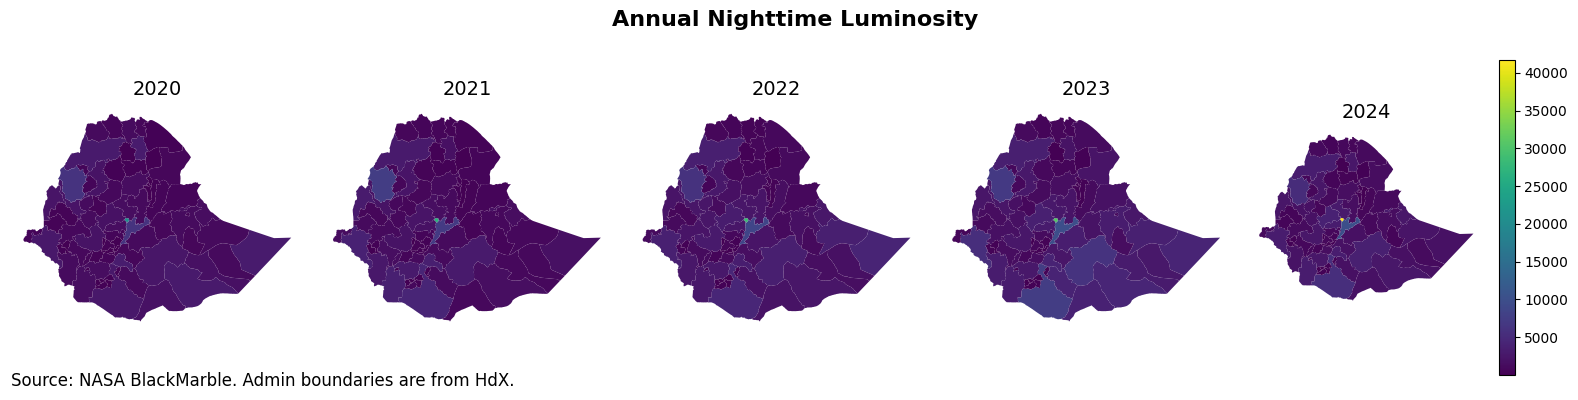

In [71]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]



# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date']>'2019-01-01']['ntl_sum'].min()
vmax = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date']>'2019-01-01']['ntl_sum'].max()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 4),  gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date'] == f'{year}-01-01']
    
    # Add the legend only to the last plot
    legend = (idx == len(years) - 1)
    
    # Plot on the respective subplot
    filtered_data.plot(
        column='ntl_sum',
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap='viridis'  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle('Annual Nighttime Luminosity', fontsize=16, y=0.95, fontweight='bold')

plt.figtext(0.01, 0.01, "Source: NASA BlackMarble. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


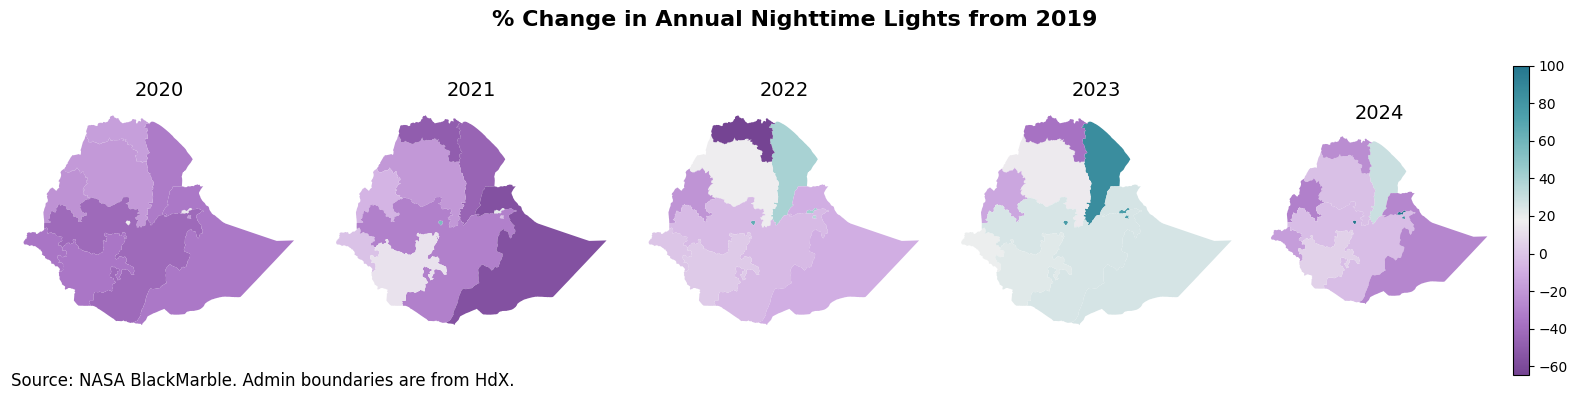

In [54]:
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]



# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date']>'2019-01-01']['percent_change_ntl_sum_2019'].min()
vmax = 100#ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date']>'2019-01-01']['percent_change'].max()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 4),  gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin1_annual_gdf[ntl_admin1_annual_gdf['date'] == f'{year}-01-01']
    
    # Add the legend only to the last plot
    legend = (idx == len(years) - 1)
    
    # Plot on the respective subplot
    filtered_data.plot(
        column='percent_change_ntl_sum_2019',
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap=custom_cmap  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle('% Change in Annual Nighttime Lights from 2019', fontsize=16, y=0.95, fontweight='bold')

plt.figtext(0.01, 0.01, "Source: NASA BlackMarble. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


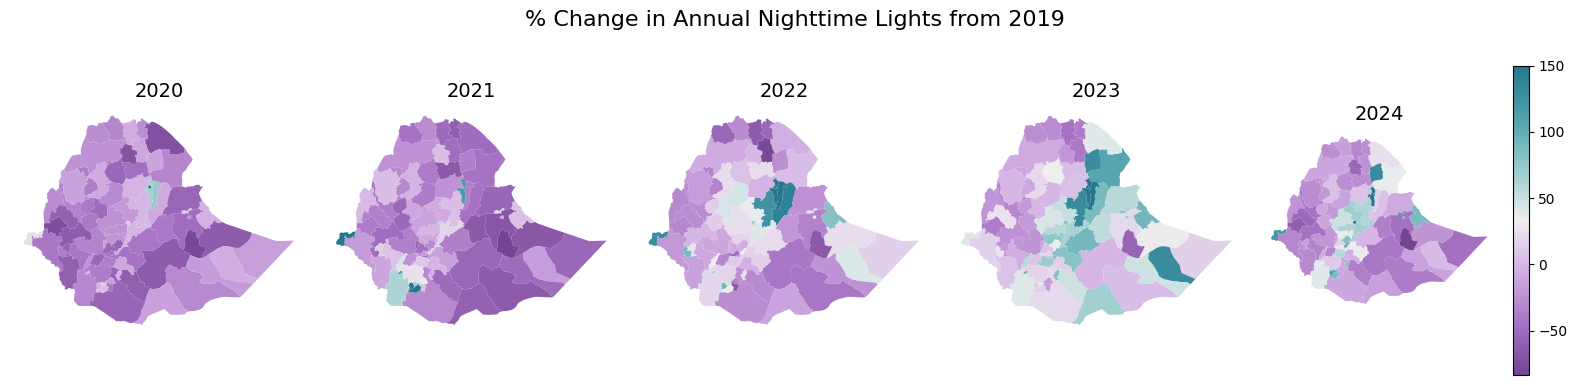

In [64]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Define the years to loop through
years = [2020, 2021, 2022, 2023, 2024]

# Calculate vmin and vmax for consistent color scaling
vmin = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date']>'2019-01-01']['percent_change_ntl_sum_2019'].min()
vmax = 150#ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date']>'2019-01-01']['percent_change'].max()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(16, 4))  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, year in enumerate(years):
    # Filter the GeoDataFrame for the given year
    filtered_data = ntl_admin2_annual_gdf[ntl_admin2_annual_gdf['date'] == f'{year}-01-01']
    
    # Add the legend only to the last plot
    legend = (idx == len(years) - 1)
    
    # Plot on the respective subplot
    filtered_data.plot(
        column='percent_change_ntl_sum_2019',
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap=custom_cmap  # Adjust color map as needed
    )
    axes[idx].set_title(f"{year}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle('% Change in Annual Nighttime Lights from 2019', fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


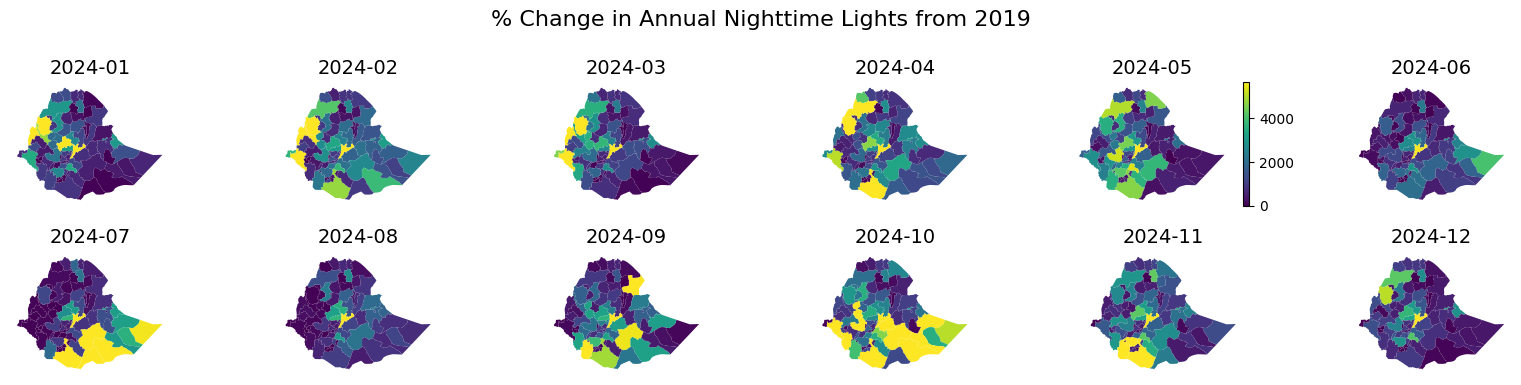

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Define the years to loop through
months_2024 = pd.date_range('2024-01-01', periods=12, freq='MS').strftime('%Y-%m').tolist()


df = ntl_admin2_monthly_gdf.copy()
df = df[(df['date']>'2023-12-31')]

# Calculate vmin and vmax for consistent color scaling
vmin = df['ntl_sum'].min()
vmax = df['ntl_sum'].max()/10

# Create subplots
fig, axes = plt.subplots(2, 6, figsize=(16, 4))  # 2 rows, 2 columns for 4 subplots
axes = axes.flatten()  # Flatten for easy indexing

for idx, month in enumerate(months_2024):
    # Filter the GeoDataFrame for the given year
    filtered_data = df[df['date'] == month]
    
    # Add the legend only to the last plot
    legend = (idx == len(years) - 1)
    
    # Plot on the respective subplot
    filtered_data.plot(
        column='ntl_sum',
        ax=axes[idx],
        legend=legend,  # Add legend only for the last plot
        vmin=vmin,
        vmax=vmax,
        cmap='viridis'  # Adjust color map as needed
    )
    axes[idx].set_title(f"{month}", fontsize=14)  # Set title to just the year
    axes[idx].axis("off")

# Add a main title
fig.suptitle('Change in Monthly Nighttime Lights in 2024', fontsize=16, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
